In [1]:
import sys
sys.path.append('..')
import jabble.model
import jabble.dataset
import jabble.loss

import astropy.units as u

import h5py
import matplotlib.pyplot as plt
import scipy.optimize

from jaxopt import GaussNewton
import jax.numpy as jnp
import jax
import numpy as np
from mpl_axes_aligner import align
import os
import jabble.physics

from jax.config import config; config.update("jax_enable_x64", True)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [2]:
import os
import datetime
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%d-%m-%y"))

In [3]:
file = h5py.File('../data/51peg_e2ds.hdf5','r')

In [4]:
file.keys()

<KeysViewHDF5 ['airms', 'bervs', 'data', 'dates', 'drifts', 'filelist', 'ivars', 'pipeline_rvs', 'pipeline_sigmas', 'xs']>

In [5]:
file['pipeline_rvs']

<HDF5 dataset "pipeline_rvs": shape (91,), type "<f8">

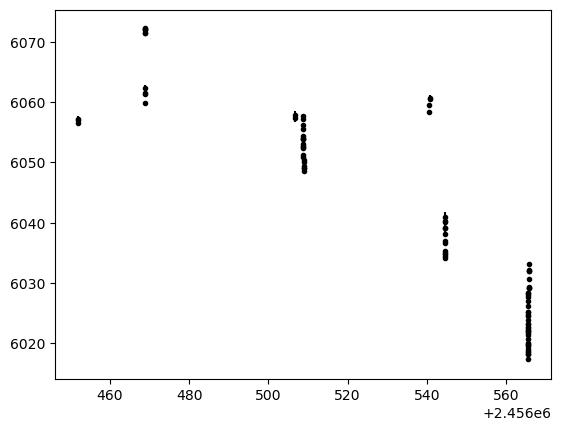

In [6]:
plt.errorbar(file['dates'][:],file['pipeline_rvs'][:]+file['bervs'][:],yerr=file['pipeline_sigmas'][:],fmt='.k')
# plt.errorbar(file['dates'][:],file['bervs'][:],yerr=file['pipeline_sigmas'][:],fmt='.k')
# plt.errorbar(file['dates'][:],file['pipeline_rvs'][:],yerr=file['pipeline_sigmas'][:],fmt='.k')
# plt.errorbar(file['dates'][:],file['drifts'][:],yerr=file['pipeline_sigmas'][:],fmt='.k')
plt.show()

In [7]:
file['data']

<HDF5 dataset "data": shape (72, 91, 4096), type "<f8">

In [8]:
TF_CPP_MIN_LOG_LEVEL=0

In [9]:
flux = np.swapaxes(jnp.array(file['data']),0,1)
# flux = flux.reshape(np.product(flux.shape[1]),-1)
print(flux.shape)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(91, 72, 4096)


In [10]:
xs = np.swapaxes(jnp.array(file['xs']),0,1)
# xs = xs.reshape(np.product(xs.shape[1]),-1)

In [11]:
yerr = np.swapaxes(np.sqrt(1/np.array(file['ivars'][:],dtype=np.float64)),0,1)
# yerr = yerr.reshape(np.product(yerr.shape[:2]),-1)
mask = np.zeros(xs.shape,dtype='bool')
mask[flux < -3.5] = True
mask[np.isinf(yerr)] = True
print(np.sum(np.isinf(yerr)))

/state/partition1/job-37873750/ipykernel_781716/3939973818.py:1: RuntimeWarning: divide by zero encountered in divide
  yerr = np.swapaxes(np.sqrt(1/np.array(file['ivars'][:],dtype=np.float64)),0,1)


105016


In [12]:
flux.shape

(91, 72, 4096)

In [13]:
dataset = jabble.dataset.Dataset(xs[:,12,1000:2000],flux[:,12,1000:2000],yerr[:,12,1000:2000],mask[:,12,1000:2000])

In [14]:
loss = jabble.loss.ChiSquare()

In [15]:
file['data'][:].shape

(72, 91, 4096)

In [16]:
init_shifts = jabble.dataset.shifts(-(file['bervs'][:]*u.m/u.s - file['pipeline_rvs'][:]*u.m/u.s))

In [17]:
resolution = 115_000
p_val = 2
dx = jabble.dataset.delta_x(2*resolution)
x_grid = np.arange(np.min(xs),np.max(xs),step=dx,dtype='float64')
vel_padding = 100 * u.km/u.s
model_grid = jabble.model.create_x_grid(x_grid,vel_padding,2*resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.IrwinHallModel_vmap(model_grid,p_val)]) + jabble.model.IrwinHallModel_vmap(model_grid,p_val)#,\
            # MyModel([jabble.model.ShiftingModel(init_shifts),jabble.model.IrwinHallModel_full(model_grid,p_val)])]

In [18]:
def make_plot(model_num):
    x_window = np.log(4550) - np.log(4549)
    lmin = np.exp(dataset.xs[0,500])
    lmax = np.exp(dataset.xs[0,600])
    lrange = np.arange(lmin,lmax,1)
    plt_unit = u.Angstrom
    epoches = 25
    r_plots = 5
    
    vel_epoch = 5
    fig, axes = plt.subplots(epoches // r_plots, r_plots,figsize=(8,8),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
    fig.suptitle(filenames[model_num])
    for plt_epoch in range((epoches//r_plots) * r_plots):
        xplot = np.linspace(np.log(lmin),np.log(lmax),dataset.xs.shape[1]*10)
        plt_min = xplot.min()+init_shifts[plt_epoch]
        plt_max = xplot.max()+init_shifts[plt_epoch]
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(plt_min,plt_max)
    
        # model_set[model_num].fix()
        # model_set[model_num].fit(0)
        # rv_model_deriv = jax.jacfwd(model_set[model_num], argnums=0)(model_set[model_num].get_parameters(),dataset.xs[plt_epoch,:],plt_epoch)
        # rv_loss_deriv = jax.jacfwd(loss, argnums=0)(model_set[model_num].get_parameters(),datasets[0],vel_epoch,model_set[model_num])
        
        model_set[model_num].fix()
    
        axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(dataset.xs[plt_epoch,:],dataset.ys[plt_epoch,:],\
                                 dataset.yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

        
        
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2,1)
    #         axes[i,j].set_yticks([])
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange))
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        
        
    fig.text(0.5, 0.04, '$\lambda$', ha='center')
    fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
    # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
    # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
    fig.text(0.96, 0.5, 'residuals', va='center', rotation=270)
    
    # plt.savefig(os.path.join(out_dir,'44-res_{}.png'.format(filenames[model_num])),dpi=300,bbox_inches='tight')
    plt.show()

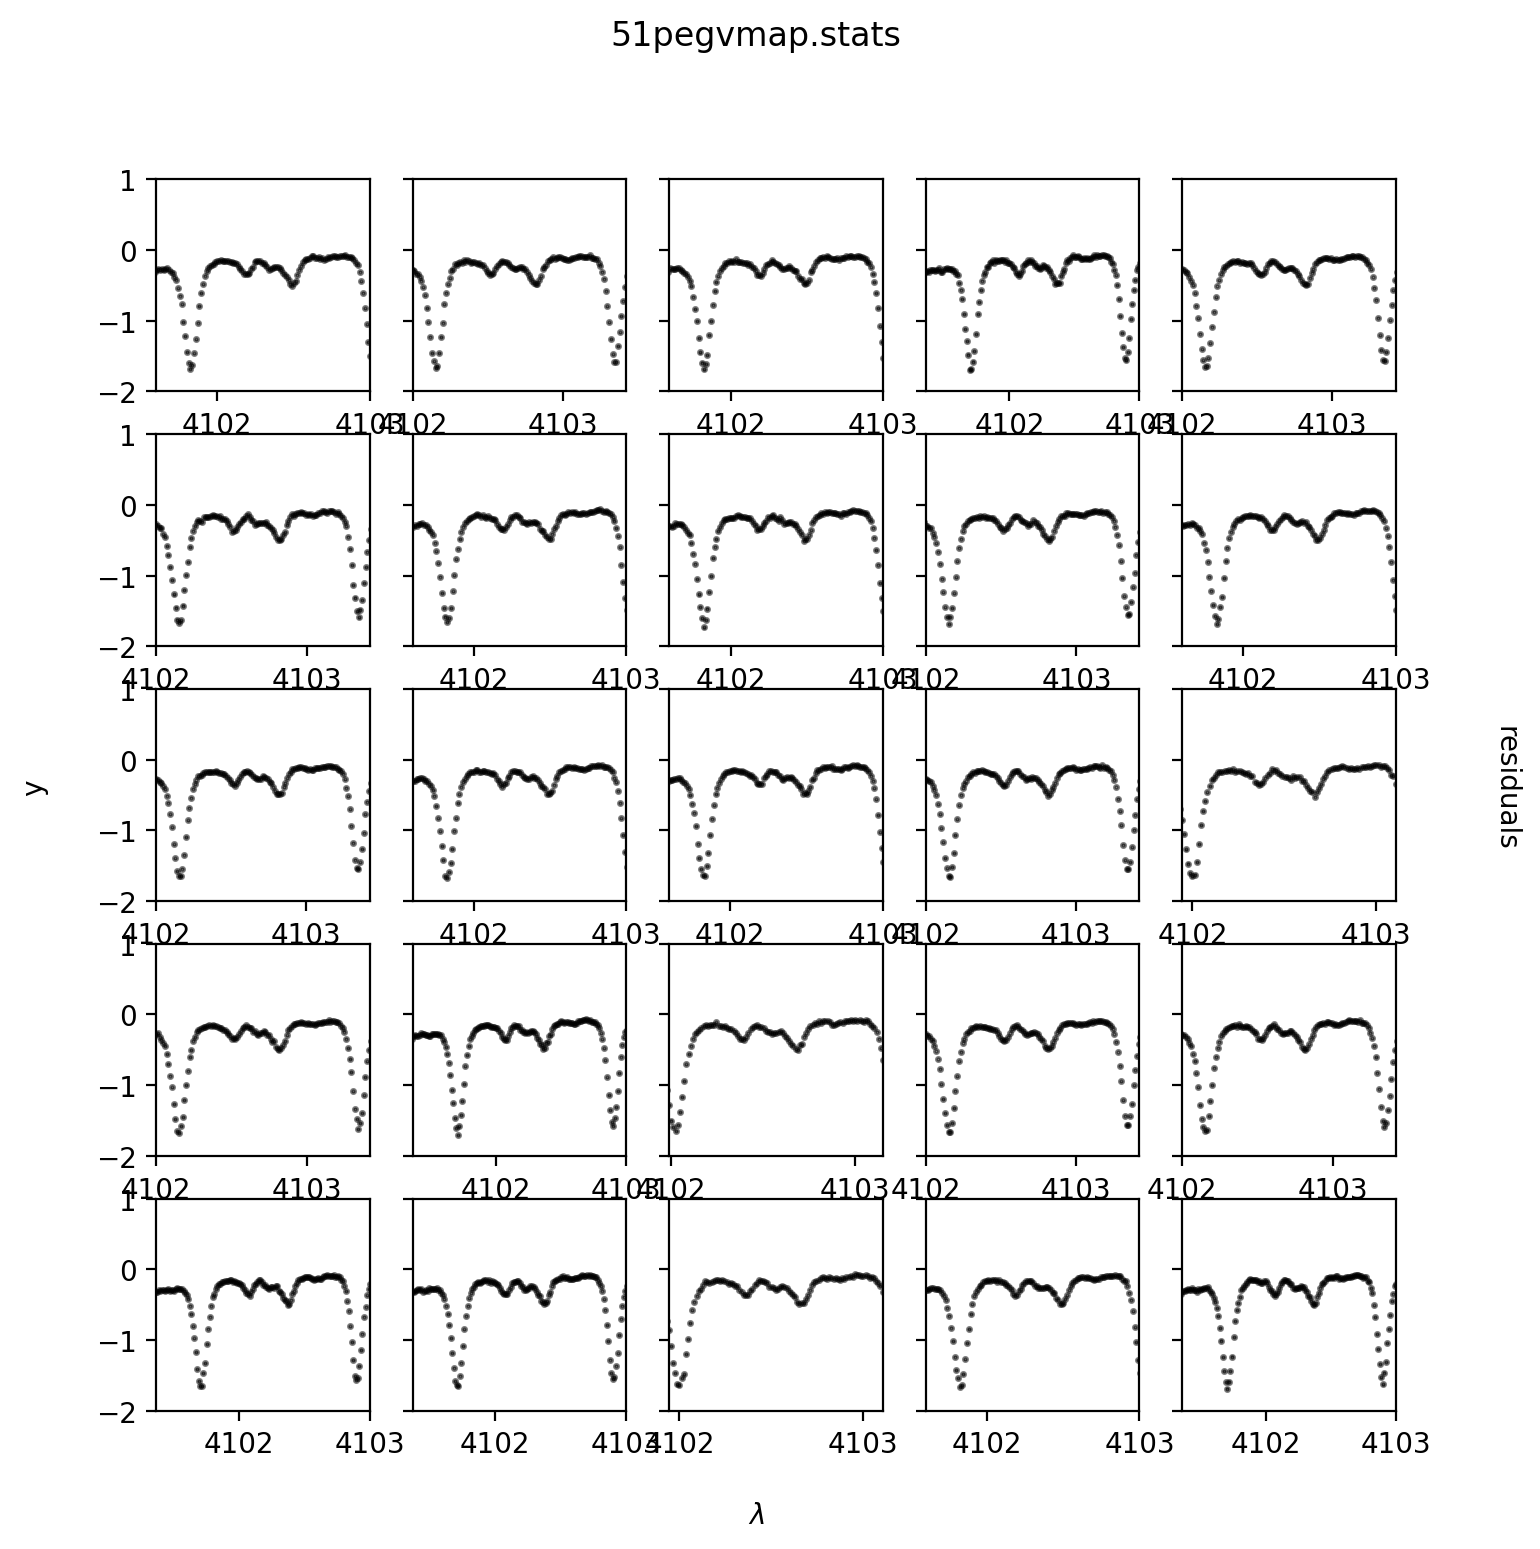

In [19]:
filename = '51pegvmap.stats'
filenames = [filename]
model_set = [model]
make_plot(0)

In [20]:
def train_cycle(model,dataset,loss):
    n_cycles = 1

    options1 = {'pgtol': 0.0}
    options2 = {'pgtol': 0.0}
    for iii in range(n_cycles):
        
        model.fix()
        model.fit(0,1)
        res1 = model.new_lbfgsb(loss,dataset,options=options1)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])
        
        model.fix()
        model.fit(1)
        res1 = model.new_lbfgsb(loss,dataset,options=options2)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])

        model.fix()
        model.fit(0,0)
        res1 = model.new_lbfgsb(loss,dataset,options=options1)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])

        model.fix()
        shift_search = jabble.physics.shifts(np.linspace(-10,10,100))
        model[0][0].parabola_fit(shift_search,loss,model,dataset)
            
        model.fix()
        model.fit(0,0)
        model.fit(0,1)
        model.fit(1)
        res1 = model.new_lbfgsb(loss,dataset,options=options2)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])
        
    return model

In [21]:
mask.shape

(91, 72, 4096)

In [22]:
import jax.experimental.sparse

In [23]:
import cProfile

In [24]:
import jabble.physics

In [ ]:
filename = '51pegvmap.stats'
cProfile.run('model=train_cycle(model,dataset,loss)',filename)

0 53
0 19
0 25


In [ ]:
# residual = loss(model.get_parameters(),dataset,plt_epoch,model)
# print(residual.shape)

In [ ]:
modelname = 'peg51vmapmodel1.mdl'
jabble.model.save(modelname,model)

In [ ]:
def make_plot(model_num):
    x_window = np.log(4550) - np.log(4549)
    lmin = np.exp(dataset.xs[0,500])
    lmax = np.exp(dataset.xs[0,600])
    lrange = np.arange(lmin,lmax,1)
    plt_unit = u.Angstrom
    epoches = 25
    r_plots = 5
    
    vel_epoch = 5
    fig, axes = plt.subplots(epoches // r_plots, r_plots,figsize=(8,8),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
    fig.suptitle(filenames[model_num])
    for plt_epoch in range((epoches//r_plots) * r_plots):
        xplot = np.linspace(np.log(lmin),np.log(lmax),dataset.xs.shape[1]*10)
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(xplot.min()+model_set[model_num][0][0].p[plt_epoch],xplot.max()+model_set[model_num][0][0].p[plt_epoch])
    
        # model_set[model_num].fix()
        # model_set[model_num].fit(0)
        # rv_model_deriv = jax.jacfwd(model_set[model_num], argnums=0)(model_set[model_num].get_parameters(),dataset.xs[plt_epoch,:],plt_epoch)
        # rv_loss_deriv = jax.jacfwd(loss, argnums=0)(model_set[model_num].get_parameters(),datasets[0],vel_epoch,model_set[model_num])
        
        model_set[model_num].fix()
    
        axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(dataset.xs[plt_epoch,:],dataset.ys[plt_epoch,:],\
                                 dataset.yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

        # true_model.fix()
        
        axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,model_set[model_num]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
        # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
    
        
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2,1)
    #         axes[i,j].set_yticks([])
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange))
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        
        res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
        residual = loss(model_set[model_num].get_parameters(),dataset,plt_epoch,model_set[model_num])
        res_ax.step(dataset.xs[plt_epoch,:],residual,where='mid',alpha=0.3,label='residual')
        res_ax.set_ylim(0.0,20)
        res_ax.set_yticks([])
        # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
        #             model_set[i][j].results[-2]['grad'][:],\
        #             where='mid',alpha=0.4,label='residual',zorder=-1)
        # res_ax.set_yticks([])
        
        # res_ax.step(x_grid,\
        #             rv_model_deriv[:,plt_epoch],\
        #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
        
    #     res_ax.step(x_grid,\
    #                 rv_loss_deriv[:,plt_epoch],\
    #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
        
    #     align_yaxis(, 0, , 0)
        
        align.yaxes(axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2./3.)

    # res.get_shared_y_axes().join(ax1, ax3)
    fig.text(0.5, 0.04, '$\lambda$', ha='center')
    fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
    # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
    # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
    fig.text(0.96, 0.5, 'residuals', va='center', rotation=270)
    
    plt.savefig(os.path.join(out_dir,'44-res_{}.png'.format(filenames[model_num])),dpi=300,bbox_inches='tight')
    plt.show()

In [ ]:
filenames = [filename]
model_set = [model]
make_plot(0)

In [ ]:
fig,ax = plt.subplots(len(model_set),figsize=(8,8),facecolor=(1,1,1),dpi=300,sharex=True,sharey=True)

epoches = dataset.xs.shape[0]
epoch_range = np.arange(0,epoches,dtype=int)
# ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')

velocities = np.array(file['pipeline_rvs'][:]+file['bervs'][:]) * u.m/u.s
for i in range(len(model_set)):
    fischer_information = np.zeros(epoches)
    for e_num in range(epoches):
        model_set[i].fix()
        model_set[i].fit(0)
        temp = jax.jacfwd(model_set[i], argnums=0)(model_set[i].get_parameters(),dataset.xs[e_num,:],e_num)
        # print(temp.shape)
        fischer_information[e_num] =  jnp.dot(temp[:,e_num]**2,dataset.yivar[e_num,:])
    
    # for j in range(len(datasets)):
    dvddx = jnp.array([jax.grad(jabble.physics.velocities)(x) for x in model_set[i][0].p])
    verr = np.sqrt(1/fischer_information) * dvddx
    # ax.hlines(y = 0.0, xmin = -2, xmax = epoches+2,linestyles='dashed',alpha=0.2,color='red')
    estimate_vel = jabble.dataset.velocities(model_set[i][0].p)
    tv = velocities.to(u.m/u.s).value   - velocities.to(u.m/u.s).value.mean()
    ev = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean()        
    # ax[i].plot(epoch_range,tv,'.r',alpha=0.5)        
    ax.errorbar(epoch_range,tv,yerr=file['pipeline_sigmas'][:],fmt='.r',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)

    # ax.errorbar(epoch_range,ev,yerr=verr,fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)

    ax.set_title('file: {} p: {}'.format(filenames[i],model_set[i][1].p_val))
plt.xlim(-0.5,epoches-0.5)
fig.text(0.04, 0.5, '$v_{truth} - v_{est}$ [$m/s$]', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'epochs', ha='center')
plt.savefig(os.path.join(out_dir,'44-dv.png'))
plt.show()